# Baseline modeling

VERSION INFO:
- training done on first data split (not considering disjointness of datasets with respect to the sites)
- the training should be extended in order to get optimal model performace (without additional measures like regularization)

GENERAL INFO:
- target model: simple multinomial logistic regression
- implementation approach: single-layer neural network with softmax (i.e. categorical cross entropy) activation
- preprocessing:
  - different methods possible
  - at this point, a simple brute-force reshaping is performed to achieve a uniform input shape
  - the model could be enhanced by data augmentation, but not done here because the architecture is trivial anyway

## Imports

In [1]:
import sys
import os
import glob

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
# sns.set_theme()

# cyberpunk theme
import mplcyberpunk
plt.style.use('cyberpunk')


import cv2 as cv

from sklearn.model_selection import train_test_split


import tensorflow as tf
import tensorflow.keras as keras


# project-specific custom functions
## export the path to custom modules
sys.path.append("../functions")
## import functions
from preprocessing import import_image_files, import_images_from_file_list

# keras.clear_session() # clear the cache of model parameters

## Data loading

In [2]:
dir_data_relative = "../data/"  # the relative directory path to all data files

### label information
df__labels = pd.read_csv(dir_data_relative+"train_labels.csv")

In [3]:
# This cells runs for about 33 seconds

# get the feature infos
X_train__info = pd.read_csv(dir_data_relative+"X_train__info.csv")
X_dev__info = pd.read_csv(dir_data_relative+"X_dev__info.csv")
X_test__info = pd.read_csv(dir_data_relative+"X_test__info.csv")

# load the features
X_train = import_images_from_file_list(dir_data_relative+X_train__info["filepath"])
X_dev = import_images_from_file_list(dir_data_relative+X_dev__info["filepath"])
X_test = import_images_from_file_list(dir_data_relative+X_test__info["filepath"])

# load the labels
y_train = pd.read_csv(dir_data_relative+"y_train.csv")
y_dev = pd.read_csv(dir_data_relative+"y_dev.csv")
y_test = pd.read_csv(dir_data_relative+"y_test.csv")

## Data preprocessing

In [4]:
# define the layer sequence for resizing and rescaling

IMG_SIZE = 200

resize_and_rescale = keras.Sequential([
    # keras.layers.Input(shape=[None, None, None, 3]),
    # keras.layers.CenterCrop(50, 100, data_format="channels_last"),
    keras.layers.Resizing(height=IMG_SIZE, width=IMG_SIZE, interpolation="bilinear"),
    keras.layers.Rescaling(scale=1./255, offset=0.0),  # rescale all pixel values to the [0, 1] range
])

In [5]:
# make a new dataset with rescaled images
## Caution: cell might take a while to run
### 40s for 5000 images

N_samples = 5000
N_samples = 10000
# N_samples = len(X_train)

X_train_rescaled = []

for image in X_train[:N_samples]:
    X_train_rescaled.append(resize_and_rescale(image))

X_train_rescaled = np.array(X_train_rescaled)
X_train_rescaled.shape

(10000, 200, 200, 3)

In [6]:
y_train__N_samples = y_train[:N_samples]

In [7]:
X_dev_rescaled = np.array([resize_and_rescale(img) for img in X_dev])
X_test_rescaled = np.array([resize_and_rescale(img) for img in X_test])

## Model training

In [8]:
model = keras.Sequential(
    [
        # resize_and_rescale,
        keras.layers.Flatten(),
        keras.layers.Dense(units=8,  # 8 output classes
                           activation="softmax"),
    ]
)

In [9]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten (Flatten)               │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [10]:
model.compile(
  # optimizer='adam',
  optimizer=keras.optimizers.Adam(learning_rate=0.01),
  loss='categorical_crossentropy',
  metrics=['accuracy']
)

History = model.fit(
    X_train_rescaled,
    y_train__N_samples,
    # validation_split=0.2,
    validation_data=(X_dev_rescaled, y_dev),
    verbose=2,
    epochs=50)

Epoch 1/50
313/313 - 15s - 47ms/step - accuracy: 0.2784 - loss: 155.9600 - val_accuracy: 0.3123 - val_loss: 112.8125
Epoch 2/50
313/313 - 14s - 45ms/step - accuracy: 0.3588 - loss: 107.5160 - val_accuracy: 0.3153 - val_loss: 137.4178
Epoch 3/50
313/313 - 19s - 60ms/step - accuracy: 0.4139 - loss: 83.4908 - val_accuracy: 0.3875 - val_loss: 87.3891
Epoch 4/50
313/313 - 14s - 45ms/step - accuracy: 0.4446 - loss: 79.5970 - val_accuracy: 0.4651 - val_loss: 102.5278
Epoch 5/50
313/313 - 11s - 35ms/step - accuracy: 0.4888 - loss: 74.6095 - val_accuracy: 0.4051 - val_loss: 133.4411
Epoch 6/50
313/313 - 7s - 23ms/step - accuracy: 0.4851 - loss: 76.1013 - val_accuracy: 0.5027 - val_loss: 109.6747
Epoch 7/50
313/313 - 7s - 22ms/step - accuracy: 0.5145 - loss: 70.7351 - val_accuracy: 0.4572 - val_loss: 97.9902
Epoch 8/50
313/313 - 22s - 69ms/step - accuracy: 0.5322 - loss: 67.9914 - val_accuracy: 0.6646 - val_loss: 44.7520
Epoch 9/50
313/313 - 6s - 18ms/step - accuracy: 0.5394 - loss: 69.2873 - va

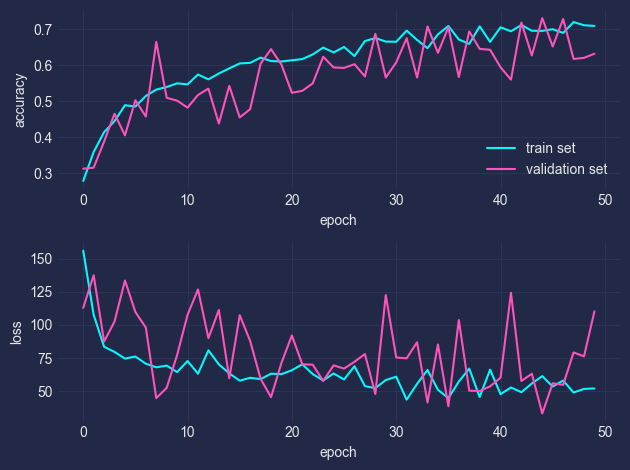

In [77]:
fig, ax = plt.subplots(2, 1)

ax[0].plot(History.history['accuracy'],label='train set')
ax[0].plot(History.history['val_accuracy'],label='validation set')
ax[0].set(xlabel='epoch',
          ylabel='accuracy')
ax[0].legend()

ax[1].plot(History.history['loss'],label='train')
ax[1].plot(History.history['val_loss'],label='val')
ax[1].set(xlabel='epoch',
          ylabel='loss')
# ax[1].legend()
fig.tight_layout()

## Model evaluation

In [12]:
y_pred_test = model.predict(X_test_rescaled)

52/52 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


In [19]:
model.evaluate(X_test_rescaled, y_test)

52/52 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - accuracy: 0.6299 - loss: 106.3021


[102.49467468261719, 0.63371741771698]

In [24]:
# Get the nominal values for the one-hot encoded labels
y_test__nominal = np.argmax(y_test, axis=-1)
y_pred_test__nominal = np.argmax(y_pred_test, axis=-1)

<Figure size 800x800 with 0 Axes>

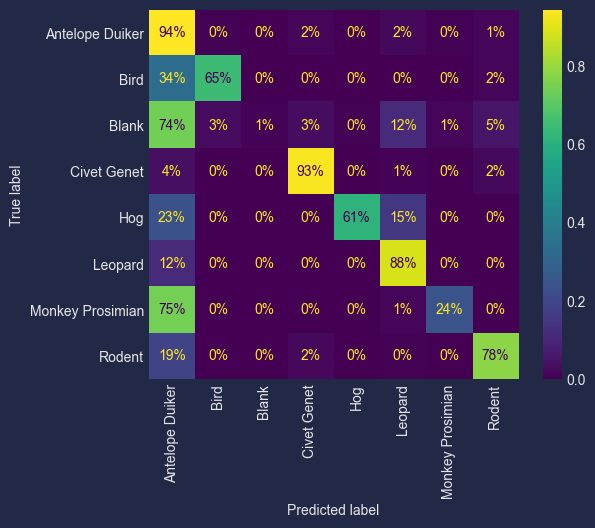

In [88]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

plt.figure(figsize = (8,8))
# cm = confusion_matrix(y_true=y_test__nominal, y_pred=y_pred_test__nominal)
# disp = ConfusionMatrixDisplay(confusion_matrix=cm,
#                               display_labels=y_test.columns,
#                             #   display_labels=np.unique(y_test__nominal)
#                             # xticks_rotation=45
#                               )

disp = ConfusionMatrixDisplay.from_predictions(
        y_true=y_test__nominal,
        y_pred=y_pred_test__nominal,
        display_labels=y_test.columns.str.title().str.replace("_", " "),  # this yields the actual label strings (in a prettified style)
        normalize="true",
        values_format=".0%",
        xticks_rotation=90,
)

                              
                            #   display_labels=np.unique(y_test__nominal)
                            # xticks_rotation=45
# plt.tick_params(axis='x', labelrotation=90)
plt.grid(False)
plt.show()

## Model saving